In [1]:
import datetime
import os
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import glob 
import gc
import dask

##
## set the directories in which your copies of the data are in the dirs.py file
from dirs import wrfdir, basedir, coorddir, snoteldir
from myutils import wrfread_gcm, metaread, read_merge, relativize_snow_values
savedir = f'{basedir}/data/tmp/'


/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Functions loaded


In [14]:
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

snotel_gdf = gpd.GeoDataFrame(data = {'site_name':snotelmeta.site_name,
                                     'elev': snotelmeta.elev,
                                     'site_number':snotelmeta.site_number,
                                     'state':snotelmeta.state,
                                     'namestr':snotelmeta.namestr,
                                     'startdt':snotelmeta.startdt}, geometry = gpd.points_from_xy(snotelmeta.lon, snotelmeta.lat))
snotel_no_ak = snotel_gdf[snotel_gdf.state != "AK"]

cdecmeta = pd.read_csv('/pscratch/sd/c/cowherd/cdecmeta.csv')
cdecmeta = cdecmeta[cdecmeta['ID'] != 'TST']

cdec_gdf = gpd.GeoDataFrame(data = {'site_name':cdecmeta['Station Name'],
                                     'elev': cdecmeta['ElevationFeet'],
                                     'site_number':cdecmeta.index,
                                     'state':cdecmeta.index,
                                     'namestr':cdecmeta.ID,
                                     'startdt':cdecmeta.index}, geometry = gpd.points_from_xy(cdecmeta.Longitude, cdecmeta.Latitude))

pillows = gpd.pd.concat([snotel_no_ak, cdec_gdf], ignore_index = True)
pillows = gpd.GeoDataFrame(pillows, geometry='geometry', crs=pillows.crs)
def assign_source(state):
    if type(state) == int:
        return 'CDEC'
    elif type(state) == str:
        return 'SNOTEL'
    else:
        return None  

pillows['network'] = pillows['state'].apply(assign_source)

domain = "d02"
lat1, lon1, z1, file =  metaread(coorddir,domain)
coords2 = xr.open_dataset(file)

In [126]:
ii = []
jj = []

for _, point in pillows.iterrows():
    x = point.geometry.x
    y = point.geometry.y
    combined_diff = np.abs(lon - x) + np.abs(lat - y)
    grid = combined_diff.values
    min_index = np.argmin(grid)
    min_index_2d = np.unravel_index(min_index, grid.shape)
    ii.append(min_index_2d[1])
    jj.append(min_index_2d[0])


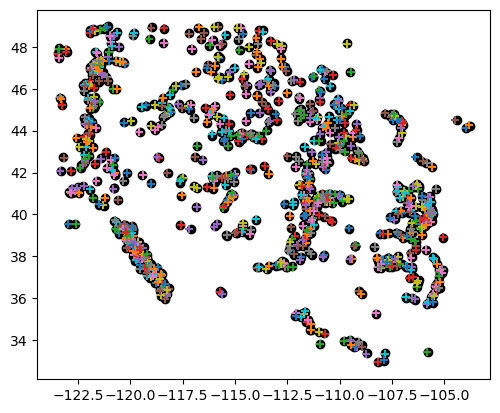

In [127]:
fig, ax = plt.subplots()
# ax.pcolormesh(coords2.XLONG[0], coords2.XLAT[0], coords2.HGT[0])
pillows.plot(ax=ax, color = 'black')
for idx in range(len(ii)):
    ax.scatter(lon[jj[idx],ii[idx]], lat[jj[idx],ii[idx]], marker = '+')
plt.show()

In [128]:
# Combine DataArrays into a Dataset
ds = xr.Dataset({'ii_dim': ('ii', ii), 'jj_dim': ('jj', jj)})

# Write the Dataset to a NetCDF file
ds.to_netcdf('d02_coordinate_pairs.nc')


we want to create some data files that contain pre-computed values from the downcsaled GCM outputs you can save these in a tmp folder while working on the project -- they are much smaller than the full  dataset but are directly repetitive

1. snowMax.nc 
2. allcorrs_huc2.npy
3. snotel_from_WRF_BC.nc
4. all_snotelWRF_365.nc
5. plots_data.pkl


In [3]:
%%time

## based on code from Stefan Rahimi
date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_ssp, date_end_ssp = "2014-09-01", "2100-08-31"

domain = "d02"
lat1, lon1, z1, file =  metaread(coorddir,domain)
coords2 = xr.open_dataset(file)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

coords = {'lat': (['lat2d','lon2d'], lat_wrf), \
                 'lon': (['lat2d','lon2d'], lon_wrf) }

gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3']

variants = ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
            'r1i1p1f1','r1i1p1f1','r2i1p1f2',
            'r1i1p2f1','r5i1p1f1','r1i1p1f1',
            ]

calendar = ['365_day','proleptic_gregorian','proleptic_gregorian',
            'proleptic_gregorian','365_day','360_day',
             '365_day','proleptic_gregorian','proleptic_gregorian',
            ]

ssps = ['ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        ]

print (len(ssps),len(calendar),len(variants),len(gcms))


snow_BC = {}
snowMax = []

keys = []

for count, igcm in enumerate(gcms):
    
    condition = ()
    
    bc = True
    var = 'snow'
    key = '%s_%s_%s' %(igcm,variants[count],ssps[count])
    var = read_merge(wrfdir,domain,var,
                                        igcm,variants[count], \
                                        date_start_hist,date_start_ssp, \
                                        date_end_hist,date_end_ssp,ssps[count],bc,
            calendar[count])
    
    snow_BC[key] = var
    
    var_x = var.groupby(var.time.dt.year).max()
    snowMax.append(var_x)

    
snowMax = xr.concat(snowMax,dim='gcm')
snowMax.to_netcdf(f'{savedir}snowMax.nc')
gc.collect()

12 9 9 9
365_day 2014-08-31 2100-08-31
cesm2 r11i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
mpi-esm1-2-lr r7i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
cnrm-esm2-1 r1i1p1f2 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 True ssp370
365_day 2014-08-31 2100-08-31
fgoals-g3 r1i1p1f1 True ssp370
360_day 2014-08-30 2100-08-30
ukesm1-0-ll r2i1p1f2 True ssp370
365_day 2014-08-31 2100-08-31
canesm5 r1i1p2f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
access-cm2 r5i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3 r1i1p1f1 True ssp370
CPU times: user 1min 59s, sys: 5min 1s, total: 7min
Wall time: 4min 31s


9738

In [ ]:
## PREP SNOTEL WRF DATA ##
jjj = x_indices
iii = y_indices
snow_SNOTELfromWRF= []
for icount, igcm in enumerate(snow_BC.keys()):
    snow_x = snow_BC[igcm].isel(lat2d=xr.DataArray(jjj,dims="site"), lon2d=xr.DataArray(iii,dims="site"))
    start_date = snow_x.time[5*365]  # 1985
    end_date = snow_x.time[35*365]   # 2015

    snow = snow_x.sel(time = slice(start_date,end_date))
    
    if icount == 0:
        times = snow.time
        
    if icount != 0:
        snow['time'] = times
        
    snow_SNOTELfromWRF.append(snow)
    print (igcm)
    
snow_SNOTELfromWRF_BC = xr.concat(snow_SNOTELfromWRF,dim='gcm')
snow_SNOTELfromWRF_BC['gcm'] = keys

zSNOTEL = z_wrf.isel(lat2d=xr.DataArray(jjj,dims="site"), lon2d=xr.DataArray(iii,dims="site")).load()
z_coords = {'zWRF': (['site'],  zSNOTEL)}

print (snow_SNOTELfromWRF_BC)

gc.collect()
snotel_from_WRF_BC.to_netcdf('snotel_from_WRF_BC.nc')


In [ ]:
%%time
## this takes 50 minutes
huc2masks = xr.open_dataset(f'{outputsdir}basin_masks_filtered.nc')

all_SDVS = []
allcorrs = {}
for basinnum in range(8):
    mask_bool = huc2masks['basin_mask'][basinnum].values.astype(bool)
    swe_local_dataset = sweMax.where(mask_bool)
    SDV_all_max = relativize_snow_values(swe_local_dataset)
    all_SDVS.append(SDV_all_max)
    maxcorr = []
    #
    allcorrs[basinnum] = {}
    #
    for gcm in range(9):
        #
        allcorrs[basinnum][gcm] = {}
        #
        for year in range(20,121):
            #
            allcorrs[basinnum][gcm][year] = []
            #
            corrs = []
            for backyear in range(year):
                try:
                    corr = xr.corr(SDV_all_max['relativized_swe'][gcm,year], SDV_all_max['relativized_swe'][gcm,backyear], dim=['lat2d', 'lon2d'])
                    corrs.append(corr.values.flatten()[0])
                except RuntimeWarning:
                    corrs.append(np.nan)
            allcorrs[basinnum][gcm][year] = corrs
        gc.collect()
    print(basinnum)
np.save(f'{basedir}/data/allcorrs_huc2', allcorrs)


In [ ]:
## snotel_extrapolated.nc
snowmax = xr.load_dataset(f'{savedir}snowMax.nc')
pillows = xr.open_dataset('d02_coordinate_pairs.nc')



In [21]:
from scipy.interpolate import griddata
from dirs import wrfdir, basedir, coorddir, snoteldir
from myutils import wrfread_gcm, metaread, read_merge, relativize_snow_values
savedir = f'{basedir}/data/tmp/'
snowmax = xr.load_dataset(f'{savedir}snowMax.nc')
pillows = xr.open_dataset('d02_coordinate_pairs.nc')
iis = pillows.ii_dim.values ## longitudes
jjs = pillows.jj_dim.values ## latitudes

sparse_pillows = xr.Dataset()

sparse_pillows['year'] = snowmax['year']
sparse_pillows['lat2d'] = snowmax['lat2d']
sparse_pillows['lon2d'] = snowmax['lon2d']

# Loop through each GCM
for gcm in snowmax['gcm'].values:
    data_array = xr.full_like(snowmax['__xarray_dataarray_variable__'].sel(gcm=gcm), np.nan)
    for idx in range(len(iis)):
        lat = jjs[idx]
        lon = iis[idx]
        lat_idx = np.where(snowmax['lat2d'].values == lat)[0]
        lon_idx = np.where(snowmax['lon2d'].values == lon)[0]
        
        if lat_idx.size > 0 and lon_idx.size > 0:
            data_array[:, lat_idx, lon_idx] = snowmax['__xarray_dataarray_variable__'].sel(gcm=gcm)[:, lat_idx, lon_idx]
    
    sparse_pillows[f'snowmax_{gcm}'] = data_array
latitudes = sparse_pillows['lat2d'].values
longitudes = sparse_pillows['lon2d'].values
years = sparse_pillows['year'].values

dense_pillows = sparse_pillows.copy()
for gcm in range(9):
    for year in years:
        values = sparse_pillows[f'snowmax_{gcm}'].sel(year=year).values
        
        # Find the coordinates where values are NaN
        nan_coords = np.argwhere(np.isnan(values))
        valid_coords = np.argwhere(~np.isnan(values))
        
        valid_values = values[~np.isnan(values)]
        interpolated_values = griddata(valid_coords, valid_values, nan_coords, method='nearest')
        interpolated_grid = values.copy()
        interpolated_grid[np.isnan(values)] = interpolated_values
        
        dense_pillows[f'snowmax_{gcm}'].loc[{'year': year}] = interpolated_grid

snowmax_vars = []
for n in range(9):
    snowmax_vars.append(new_dataset2[f'snowmax_{n}'])
dense_pillows_stacked = xr.concat(snowmax_vars, dim='gcm')
dense_pillows_stacked.to_netcdf('../snowpillow_extrapolated.nc')